In [38]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from datetime import datetime as dt
import numpy as np
import pandas as pd
import pytz
import sched
import speedtest as st
import time

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter


plt.style.use('dark_background')

In [3]:
def get_new_speeds() -> tuple[float, float, float]:
    try:
        speed_test = st.Speedtest()    
        speed_test.get_best_server()
    except:
        return None, None, None
    
    # Get ping (miliseconds)
    ping = speed_test.results.ping
    # Perform download and upload speed tests (bits per second)
    download = speed_test.download()
    upload = speed_test.upload()

    # Convert download and upload speeds to megabits per second
    download_mbs = round(download / (10**6), 2)
    upload_mbs = round(upload / (10**6), 2)

    return (ping, download_mbs, upload_mbs)


def update_csv(internet_speeds: tuple[float, float, float], csv_file_name: str = "internet_speeds_dataset.csv", verbose: bool = True):
    time_now = dt.now().replace(tzinfo=pytz.timezone("Europe/London")).strftime('%Y-%m-%d %H:%M:%S.%f %Z')
    if verbose:
        print(time_now)

    # Load the CSV to update
    try:
        csv_dataset = pd.read_csv(csv_file_name, sep=",", index_col="Time")
    # If there's an error, assume the file does not exist and create\
    # the dataset from scratch
    except:
        csv_dataset = pd.DataFrame(
            list(),
            columns=["Ping (ms)", "Download (Mb/s)", "Upload (Mb/s)"]
        )

    # Create a one-row DataFrame for the new test results
    results_df = pd.DataFrame(
        [[ internet_speeds[0], internet_speeds[1], internet_speeds[2] ]],
        columns=["Ping (ms)", "Download (Mb/s)", "Upload (Mb/s)"],
        index=[time_now]
    )

    updated_df = csv_dataset.append(results_df, sort=False)
    updated_df.loc[~updated_df.index.duplicated(keep="last")].to_csv(csv_file_name, sep=",", index_label="Time")
    
    
def get_new_speeds_and_update(csv_file_name: str = "internet_speeds_dataset.csv", verbose: bool = True):
    update_csv(get_new_speeds(), csv_file_name, verbose)

In [4]:
scheduler = sched.scheduler(time.time, time.sleep)


def repeat_task():
    scheduler.enter(0, 1, get_new_speeds_and_update, ())
    scheduler.enter(30, 1, repeat_task, ())


repeat_task()
scheduler.run()

2024-08-04 00:27:48.299282 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:28:18.056832 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:28:48.741004 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:29:20.137758 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:29:53.670139 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:30:18.206440 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:30:48.921745 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:31:18.433087 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:31:55.384374 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:32:24.601786 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:32:48.502615 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:33:23.766395 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:33:48.210211 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:34:20.382642 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:34:49.246667 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:35:18.334773 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:35:48.276399 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:36:19.199426 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:36:51.826118 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:37:18.034095 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:37:49.450217 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:38:19.368373 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:38:48.093055 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:39:18.219343 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:39:48.403733 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:40:18.575562 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:40:48.379941 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:41:18.245816 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:41:48.455551 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:42:19.200623 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:42:48.337192 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:43:19.203263 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:43:49.379433 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:44:18.150514 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:44:48.731138 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:45:18.528081 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:45:48.156261 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:46:18.487284 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:46:48.636780 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:47:18.520147 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:47:48.496604 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:48:18.449012 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:48:48.342090 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:49:18.797038 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:49:48.280212 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:50:18.940140 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:50:48.287347 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:51:18.246403 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:51:48.545581 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:52:18.715877 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:52:48.327791 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:53:18.351390 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:53:59.970822 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:54:22.847793 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:54:52.188530 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:55:33.804022 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:55:56.116952 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:56:25.998330 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:56:56.106788 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:57:26.099199 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:57:55.868035 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:58:25.971815 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:58:56.931315 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:59:25.991938 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 00:59:56.878184 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:00:04.893727 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:01:07.344234 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:01:29.504269 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:01:59.538748 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:02:30.776268 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:02:59.599793 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:03:30.198580 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:04:06.758849 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:04:29.526925 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:04:59.675136 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:05:29.731781 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:06:01.031070 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:06:29.685295 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:07:09.732662 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:07:31.860641 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:08:02.068048 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:08:35.595380 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:09:22.551867 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:09:44.758504 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:10:15.956418 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:10:45.902801 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:11:15.687027 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:11:46.165811 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:12:15.330303 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:12:44.966451 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:13:14.840810 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:13:44.937502 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:14:14.570890 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:14:45.000166 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:15:14.695320 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:15:46.051332 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:16:15.922873 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:16:45.098100 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:17:15.124684 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:17:48.348409 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:18:16.139573 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:18:45.074434 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:19:22.419909 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:19:44.822685 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:20:15.535483 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:20:45.120624 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:21:15.051220 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:21:44.905095 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:22:14.932616 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:22:46.015521 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:23:15.311485 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:23:46.972764 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:24:15.585086 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:24:45.669258 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:25:18.071124 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:25:52.066332 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:26:16.865829 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:26:45.409186 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:27:15.792188 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:27:44.887368 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:28:15.331234 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:28:45.005862 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:29:17.067055 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:29:45.172803 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:30:15.037398 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:30:45.124810 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:31:15.117675 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:31:44.824858 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:32:22.178173 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:32:44.920623 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:33:16.285825 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:33:45.287643 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:34:14.928780 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:34:46.314495 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:35:15.172794 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:35:44.844971 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:36:16.470192 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:36:45.236019 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:37:16.073439 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:37:44.902486 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:38:14.888800 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:38:44.896948 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:39:15.063702 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:39:45.151328 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:40:16.798743 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:40:55.709134 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:41:17.948628 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:41:47.749127 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:42:17.848265 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:42:48.109015 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:43:17.485122 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:43:47.777737 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:44:25.995629 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:44:47.885446 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:45:21.104127 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:45:48.897730 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:46:19.881203 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:46:47.955191 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:47:18.083206 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:47:48.194673 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:48:19.035357 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:48:48.010494 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:49:18.138990 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:49:48.093093 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:50:19.199998 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:50:57.769463 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:51:19.838330 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:51:49.702814 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:52:19.579522 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:52:49.640297 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:53:19.835693 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:53:49.736671 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:54:19.723459 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:54:55.870921 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:55:21.151184 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:55:50.063991 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:56:29.992613 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:56:52.592108 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:57:21.952724 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:57:53.354700 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:58:21.952664 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:58:52.289294 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:59:22.558590 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 01:59:51.951912 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


2024-08-04 02:00:06.224276 LMT


/tmp/ipykernel_66641/306962918.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = csv_dataset.append(results_df, sort=False)


ConfigRetrievalError: HTTP Error 403: Forbidden

In [50]:
df = pd.read_csv("internet_speeds_dataset.csv", sep=",")
df['Time'] = df['Time'].str.replace(" LMT", "", regex=True)
df["Time"] = pd.to_datetime(df["Time"]).dt.tz_localize("Europe/London")
df = df.set_index("Time").sort_index()

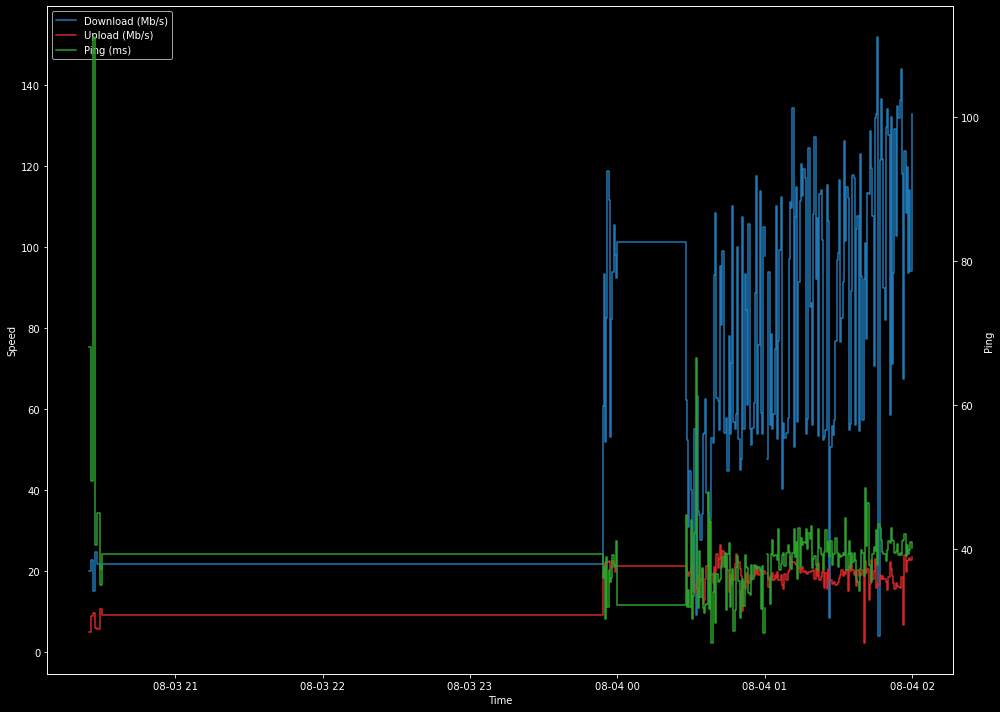

In [59]:
fig, ax1 = plt.subplots(figsize=(14, 10), nrows=1, ncols=1)

lines_1 = ax1.step(df.index, df["Download (Mb/s)"], where="post", color="tab:blue", label="Download (Mb/s)")
lines_2 = ax1.step(df.index, df["Upload (Mb/s)"], where="post", color="tab:red", label="Upload (Mb/s)")

ax1.set_xlabel("Time")
ax1.set_ylabel("Speed")

ax2 = ax1.twinx()
lines_3 = ax2.step(df.index, df["Ping (ms)"], where="post", color="tab:green", label="Ping (ms)")

ax2.set_ylabel("Ping")

lines = lines_1 + lines_2 + lines_3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper left")

plt.tight_layout()
plt.show()